# Overview

https://ijritcc.org/index.php/ijritcc/article/download/8119/6540

In [1]:
import os
import re
import tempfile
import warnings

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from lightgbm import LGBMClassifier
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
from pyspark.sql import SparkSession
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from JapanHorseRaceAnalytics.utilities.base import get_base_dir, read_hive_table
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_binary_classifier_statistics,
)
from JapanHorseRaceAnalytics.utilities.mlflow import get_colspecs
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

# Set pandas display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42

In [2]:
warehouse_dir = f"{get_base_dir()}/spark-warehouse"
postgres_driver_path = f"{get_base_dir()}/jars/postgresql-42.7.1.jar"

spark = (
    SparkSession.builder.appName("20240211_competitors")
    .config("spark.driver.memory", "20g")
    .config("spark.sql.warehouse.dir", warehouse_dir)
    .config("spark.jars", postgres_driver_path)
    .config("spark.executor.extraClassPath", postgres_driver_path)
    .config("spark.driver.extraClassPath", postgres_driver_path)
    .enableHiveSupport()
    .getOrCreate()
)

24/02/25 17:38:12 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/02/25 17:38:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/02/25 17:38:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=None,
    use_cache=True,
)

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# drop from data where meta_int_race_horses_異常区分 != '0'
data = data[(data["meta_int_race_horses_異常区分"] == "0")]

data = data.reset_index(drop=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-02-25T08:38:14.059626Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_発走日時,meta_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,cat_事前_レース条件_トラック情報_右左,cat_事前_レース条件_トラック情報_内外,cat_事前_レース条件_種別,cat_事前_レース条件_条件,cat_事前_レース条件_記号,cat_事前_レース条件_重量,cat_事前_レース条件_グレード,num_事前_馬場差,num_頭数,cat_トラック種別,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,cat_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,meta_int_race_horses_血統登録番号,meta_int_race_horses_発走日時,meta_int_race_horses_異常区分,num_事前ＩＤＭ,cat_事前脚質,num_事前単勝オッズ,num_事前複勝オッズ,cat_事前馬体,cat_事前気配コード,cat_事前上昇度,cat_事前クラスコード,num_事前テン指数,num_事前ペース指数,num_事前上がり指数,num_負担重量,num_馬体重,num_馬体重増減,cat_性別,cat_トラック種別瞬発戦好走馬,cat_トラック種別消耗戦好走馬,num_一走前不利,num_二走前不利,num_三走前不利,num_一走前着順,num_二走前着順,num_三走前着順,num_四走前着順,num_五走前着順,num_六走前着順,num_1走前上昇度,num_2走前上昇度,num_3走前上昇度,num_4走前上昇度,num_5走前上昇度,num_騎手指数,num_情報指数,num_オッズ指数,num_パドック指数,num_総合指数,cat_馬具変更情報,cat_脚元情報,cat_見習い区分,cat_オッズ印,cat_パドック印,cat_直前総合印,cat_距離適性,num_ローテーション,num_基準オッズ,num_基準人気順位,num_基準複勝オッズ,num_基準複勝人気順位,num_特定情報◎,num_特定情報○,num_特定情報▲,num_特定情報△,num_特定情報×,num_総合情報◎,num_総合情報○,num_総合情報▲,num_総合情報△,num_総合情報×,...,num_競争相手平均調教師1位完走,num_競争相手調教師1位完走標準偏差,num_競争相手最高調教師トップ3完走,num_競争相手最低調教師トップ3完走,num_競争相手平均調教師トップ3完走,num_競争相手調教師トップ3完走標準偏差,num_競争相手最高調教師1位完走率,num_競争相手最低調教師1位完走率,num_競争相手平均調教師1位完走率,num_競争相手調教師1位完走率標準偏差,num_競争相手最高調教師トップ3完走率,num_競争相手最低調教師トップ3完走率,num_競争相手平均調教師トップ3完走率,num_競争相手調教師トップ3完走率標準偏差,num_競争相手最高調教師場所レース数,num_競争相手最低調教師場所レース数,num_競争相手平均調教師場所レース数,num_競争相手調教師場所レース数標準偏差,num_競争相手最高調教師場所1位完走,num_競争相手最低調教師場所1位完走,num_競争相手平均調教師場所1位完走,num_競争相手調教師場所1位完走標準偏差,num_競争相手最高調教師場所トップ3完走,num_競争相手最低調教師場所トップ3完走,num_競争相手平均調教師場所トップ3完走,num_競争相手調教師場所トップ3完走標準偏差,num_競争相手最高調教師場所1位完走率,num_競争相手最低調教師場所1位完走率,num_競争相手平均調教師場所1位完走率,num_競争相手調教師場所1位完走率標準偏差,num_競争相手最高調教師場所トップ3完走率,num_競争相手最低調教師場所トップ3完走率,num_競争相手平均調教師場所トップ3完走率,num_競争相手調教師場所トップ3完走率標準偏差,num_競争相手最高調教師本賞金累計,num_競争相手最低調教師本賞金累計,num_競争相手平均調教師本賞金累計,num_競争相手調教師本賞金累計標準偏差,num_競争相手最高調教師1位完走平均賞金,num_競争相手最低調教師1位完走平均賞金,num_競争相手平均調教師1位完走平均賞金,num_競争相手調教師1位完走平均賞金標準偏差,num_競争相手最高調教師レース数平均賞金,num_競争相手最低調教師レース数平均賞金,num_競争相手平均調教師レース数平均賞金,num_競争相手調教師レース数平均賞金標準偏差,num_競争相手平均調教師レース数差,num_競争相手平均調教師1位完走差,num_競争相手平均調教師トップ3完走差,num_競争相手平均調教師1位完走率差,num_競争相手平均調教師トップ3完走率差,num_競争相手平均調教師場所レース数差,num_競争相手平均調教師場所1位完走差,num_競争相手平均調教師場所トップ3完走差,num_競争相手平均調教師場所1位完走率差,num_競争相手平均調教師場所トップ3完走率差,num_競争相手平均調教師本賞金累計差,num_競争相手平均調教師1位完走平均賞金差,num_競争相手平均調教師レース数平均賞金差,meta_int_combinations_レースキー,meta_int_combinations_馬番,num_馬騎手レース数,num_馬騎手1位完走,num_馬騎手1位完走率,num_馬騎手トップ3完走,num_馬騎手トップ3完走率,num_馬騎手初二走,num_馬騎手同騎手,num_馬騎手場所レース数,num_馬騎手場所1位完走,num_馬騎手場所1位完走率,num_馬騎手場所トップ3完走,num_馬騎手場所トップ3完走率,num_馬調教師レース数,num_馬調教師1位完走,num_馬調教師1位完走率,num_馬調教師トップ3完走,num_馬調教師トップ3完走率,num_馬調教師初二走,num_馬調教師同調教師,num_馬調教師場所レース数,num_馬調教師場所1位完走,num_馬調教師場所1位完走率,num_馬調教師場所トップ3完走,num_馬調教師場所トップ3完走率,meta_int_race_weather_レースキー,num_temperature,num_precipitation,num_snowfall,num_snow_depth,num_wind_speed,cat_wind_direction,num_solar_radiation,num_local_air_pressure,num_sea_level_air_pressure,num_relative_humidity,num_vapor_pressure,num_dew_point_temperature,cat_weather,num_visibility
0,01011103,04,6.0,0.0,False,0,False,0,01011103,2001-08-04 01:45:00,01,3,1200,20,1,1,12,A3,102,3,None,NaN,16,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011103,04,98102049,2001-08-04 01:45:00,0,36.0,好位差し,11.5,2.9,None,None,3,18,-12.4,-21.1,-10.9,550,476.0,14,牡,True,False,0.0,0.0,0.0,7.0,2.0,7.0,NaN,NaN,NaN,3,3,3,None,None,0.4,0.4,0.0,1.8,38.6,0,0,0,None,4,4,5,4.0,16.8,6,3.4,6,0,0,0,10,0,3,6,8,87,0,...,34.133333,18.575492,204,32,98.066667,44.395896,0.162376,0.027668,0.075334,0.036725,0.403960,0.120735,0.213261,0.076365,47,3,18.733333,12.390677,8,0,2.066667,2.112397,15,0,4.733333,4.464178,0.333333,0.0,0.094180,0.088041,0.5,0.000000,0.207743,0.136352,231606.0,14187.0,65859.266667,53242.331542,1687.439024,567.857143,913.419366,273.792817,458.625743,49.167979,141.408061,101.993179,73.000000,-3.133333,-5.066667,-0.016287,-0.036119,-6.733333,-1.066667,-0.733333,-0.010847,0.12559

In [4]:
data_ = pd.DataFrame(index=data.index)

# Meta columns
data_["レースキー"] = data["meta_レースキー"]
data_["発走日時"] = data["meta_発走日時"]
data_["馬番"] = data["meta_馬番"]
data_["着順"] = data["meta_着順"]
data_["複勝的中"] = data["meta_複勝的中"]
data_["複勝オッズ"] = data["num_事前複勝オッズ"]
data_["複勝払戻金"] = data["meta_複勝払戻金"]
data_["血統登録番号"] = data["meta_int_race_horses_血統登録番号"]

# Features
data_["枠番"] = data["cat_枠番"].astype(int)
data_["前走距離差"] = data["num_前走距離差"]
data_["距離"] = data["cat_距離"]
data_["年齢"] = data["num_年齢"]
data_["馬体重"] = data["num_馬体重"]
data_["馬体重増減"] = data["num_馬体重増減"]
data_["負担重量"] = data["num_負担重量"]
data_["頭数"] = data["num_頭数"]
data_["トラック種別"] = data["cat_トラック種別"]
data_["情報指数"] = data["num_情報指数"]
data_["騎手指数"] = data["num_騎手指数"]
data_["総合情報◎"] = data["num_総合情報◎"]
data_["競争相手平均総合指数差"] = data["num_競争相手平均総合指数差"]
data_["競争相手平均入厩何日前"] = data["num_競争相手平均入厩何日前"]

# Filtering
data_ = data_[data_["発走日時"].dt.year >= 2011]


# fmt: off
categories = [
    ["距離", [1000, 1150, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3200, 3400, 3600]],
    ["枠番", [1, 2, 3, 4, 5, 6, 7, 8]],
]
category_keys = [category[0] for category in categories] if categories else []
category_values = [category[1] for category in categories] if categories else []
num_cols = [
    "前走距離差",
    "年齢",
    "馬体重増減",
    "負担重量",
    "頭数",
    "情報指数",
    "騎手指数",
    "総合情報◎",
    "競争相手平均総合指数差",
]
num_null_cols = [
    "馬体重",  # 95% of 馬体重 null values are where 異常区分 != 0
    "競争相手平均入厩何日前"
]
cat_cols = [
    "トラック種別"
]
meta_cols = ["レースキー", "複勝的中", "複勝払戻金"]
all_cols = category_keys + num_cols + num_null_cols + cat_cols + meta_cols
# fmt: on

# preprocessor = ColumnTransformer(
#     transformers=[
#         # fmt: off
#         ("ord", OrdinalEncoder(categories=category_values), category_keys),
#         ("num", StandardScaler(), num_cols),
#         ("num_null", Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]), num_null_cols),
#         ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
#         ("meta", "passthrough", meta_cols)
#         # fmt: on
#     ],
#     remainder="drop",
# )

# pipeline = ImblearnPipeline(
#     steps=[
#         ("preprocessor", preprocessor),
#         ("smote", SMOTE(random_state=random_state)),
#         ("classifier", LGBMClassifier(random_state=random_state)),
#     ]
# )

In [5]:
X = data_
y = data_["複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (489263, 22)
X_test: (122316, 22)
y_train: (489263,)
y_test: (122316,)


In [6]:
def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    df_payout: pd.DataFrame,
    experiment_name: str,
):
    """
    df_payout should have the same index as *_test and have the following columns:
    * レースキー
    * 馬番
    * 距離
    * 発走日時
    * 年齢
    * 場コード
    * payout - amount won if betting 100 yen.
    """

    def train(params):
        def profit_loss(row, payout_column_name, bet_amount=100):
            if row["pred"] and row["actual"]:
                payout = row[payout_column_name] * (bet_amount / 100)
                return payout - bet_amount
            elif row["pred"] and not row["actual"]:
                return -bet_amount
            else:
                return 0

        mlflow.set_experiment(experiment_name=experiment_name)
        with mlflow.start_run():
            mlflow.log_params(params)

            preprocessor = ColumnTransformer(
                transformers=[
                    # fmt: off
                    ("ord", OrdinalEncoder(categories=category_values), category_keys),
                    ("num", StandardScaler(), num_cols),
                    ("num_null", Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]), num_null_cols),
                    ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
                    # ("meta", "passthrough", meta_cols)
                    # fmt: on
                ],
                remainder="drop",
            )
            model = ImblearnPipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("smote", SMOTE(random_state=random_state)),
                    ("classifier", LGBMClassifier(**params)),
                ]
            )

            model.fit(X_train, y_train)
            mlflow.sklearn.log_model(sk_model=model, artifact_path="model")

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            metrics = {
                "loss": log_loss(y_test, y_pred_proba),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }
            mlflow.log_metrics(metrics)

            # Calculate payout rates by group
            results = pd.concat(
                [
                    df_payout,
                    pd.DataFrame(
                        np.c_[y_test, y_pred, y_pred_proba],
                        columns=["actual", "pred", "pred_proba_true"],
                    ),
                ],
                axis=1,
            )
            payout_all = calculate_binary_classifier_statistics(
                results, group_by=None, payout_column_name="payout"
            )
            payout_month = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month,
                payout_column_name="payout",
            )
            payout_distance = calculate_binary_classifier_statistics(
                results,
                group_by=pd.cut(x=results["距離"], bins=[0, 1400, 1800, 10000]),
                payout_column_name="payout",
            )
            payout_season = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month % 12 // 3,
                payout_column_name="payout",
            )
            payout_year = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.year,
                payout_column_name="payout",
            )
            payout_age = calculate_binary_classifier_statistics(
                results,
                group_by=pd.cut(results["年齢"], bins=[0, 3, 6, 100]),
                payout_column_name="payout",
            )
            payout_racetrack = calculate_binary_classifier_statistics(
                results, group_by=results["場コード"], payout_column_name="payout"
            )
            payout = (
                pd.concat(
                    [
                        pd.DataFrame(payout_all).T.assign(group="all"),
                        pd.DataFrame(payout_month).T.assign(group="month"),
                        pd.DataFrame(payout_distance).T.assign(group="distance"),
                        pd.DataFrame(payout_season).T.assign(group="season"),
                        pd.DataFrame(payout_year).T.assign(group="year"),
                        pd.DataFrame(payout_age).T.assign(group="horse_age"),
                        pd.DataFrame(payout_racetrack).T.assign(group="racetrack"),
                    ],
                    axis=0,
                )
                .rename_axis(index="part")
                .reset_index()
            )
            # Move "group" and "part" columns to the first position in this dataframe
            payout = payout[
                ["group", "part"]
                + [c for c in payout.columns if c not in ["group", "part"]]
            ]

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Plot payout rates by group
            sns.set_theme(style="whitegrid")
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            for (group, df), ax in zip(payout.groupby("group"), axes.flatten()):
                sns.barplot(x="part", y="payout_rate", data=df, ax=ax)
                ax.set_title(group)
                ax.set_ylim(0, 150)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                ax.set_ylabel("payout rate")
                ax.set_xlabel("")
                ax.yaxis.set_major_formatter(ticker.PercentFormatter())
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Plot bank balance over time
            results["profit_loss"] = results.apply(
                profit_loss, args=("payout", 100), axis=1
            )
            daily_profit_loss = results.groupby("発走日時")["profit_loss"].sum()
            bank_balance = daily_profit_loss.cumsum()
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(1, 1, 1)
            ax.plot(bank_balance.index, bank_balance.values)
            ax.set_title("Bank Balance")
            ax.set_xlabel("Date")
            ax.set_ylabel("Bank Balance")
            ax.grid(True)
            ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
            with tempfile.NamedTemporaryFile(
                prefix="bank_balance_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Confusion Matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", ax=ax1)
            ax1.set_xlabel("Predicted")
            ax1.set_ylabel("Actual")
            ax1.set_title("Confusion Matrix")
            sns.heatmap(
                conf_matrix / conf_matrix.sum(axis=1)[:, None],
                annot=True,
                fmt=".2%",
                cmap="Blues",
                ax=ax2,
            )
            ax2.set_xlabel("Predicted")
            ax2.set_ylabel("Actual")
            ax2.set_title("Normalized Confusion Matrix")
            with tempfile.NamedTemporaryFile(prefix="confusion_matrix_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            _, ax = plt.subplots(figsize=(10, 10))
            ax.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
            ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.0])
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title("Receiver Operating Characteristic")
            ax.legend(loc="lower right")
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances
            feature_importances = zip(
                model.named_steps["preprocessor"].get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(
                    data=feature_importances, columns=["feature", "importance"]
                )
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)
            font_properties = fm.FontProperties(
                fname="/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
            )

            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(10, 12))
            ax = sns.barplot(x="importance", y="feature", data=feature_importances_df.iloc[:50])
            ax.set_title("Feature Importances (Top 50)", fontproperties=font_properties)
            ax.set_xlabel("Importance", fontproperties=font_properties)
            ax.set_ylabel("Features", fontproperties=font_properties)
            for label in ax.get_yticklabels():
                label.set_fontproperties(font_properties)
            with tempfile.NamedTemporaryFile(prefix="feature_importance_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

In [7]:
space = {
    "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"]),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "objective": "binary",
    "class_weight": "balanced",
    "verbose": -1,
    "seed": 80,
}

In [8]:
df_payout_renamed_columns = {
    "meta_レースキー": "レースキー",
    "meta_馬番": "馬番",
    "cat_距離": "距離",
    "meta_発走日時": "発走日時",
    "meta_複勝払戻金": "payout",
    "num_年齢": "年齢",
    "meta_場コード": "場コード",
    "num_事前複勝オッズ": "odds",
}

df_payout = (
    data.iloc[X_test.index]
    .reset_index(drop=True)
    .rename(columns=df_payout_renamed_columns)[df_payout_renamed_columns.values()]
)

experiment_name = "20240225_smote"
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train,
    y_train,
    X_test,
    y_test,
    df_payout=df_payout,
    experiment_name=experiment_name,
)

In [78]:
# serial
# trials = Trials()
# fmin(
#     fn=fn,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=1,
#     trials=trials,
#     trials_save_file="trials_20240225_smote.pkl",
# )

# parallel
trials = SparkTrials(parallelism=3, spark_session=spark)
fmin(
    fn=fn,
    space=space,
    algo=tpe.suggest,
    max_evals=60,
    trials=trials,
    trials_save_file="trials_20240225_smote.pkl",
)

  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.001963 seconds
TPE using 0 trials
build_posterior_wrapper took 0.019478 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.001894 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.006312 secondse 1:>                  (0 + 1) / 1]
TPE using 3/3 trials with best loss inf
Closing down clientserver connection                                            


  2%|▏         | 1/60 [00:49<48:27, 49.28s/trial, best loss: 0.4107942988987561]

build_posterior_wrapper took 0.002090 secondse 2:>                  (0 + 1) / 1]
TPE using 4/4 trials with best loss 0.410794
Closing down clientserver connection                                            


  3%|▎         | 2/60 [00:51<20:45, 21.48s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001814 seconds
TPE using 5/5 trials with best loss 0.407539
Closing down clientserver connection                                            


  5%|▌         | 3/60 [01:00<15:00, 15.80s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002020 secondse 4:>                  (0 + 1) / 1]
TPE using 6/6 trials with best loss 0.407539
Closing down clientserver connection                                            


  7%|▋         | 4/60 [01:51<27:48, 29.79s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001828 secondse 4:>                  (0 + 1) / 1]
TPE using 7/7 trials with best loss 0.407539
Closing down clientserver connection                                            


  8%|▊         | 5/60 [02:36<32:24, 35.35s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001856 secondse 4:>                  (0 + 1) / 1]
TPE using 8/8 trials with best loss 0.407539
Closing down clientserver connection                                            


 10%|█         | 6/60 [03:20<34:13, 38.03s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001996 secondse 7:>                  (0 + 1) / 1]
TPE using 9/9 trials with best loss 0.407539
Closing down clientserver connection                                            
Closing down clientserver connection


 13%|█▎        | 8/60 [03:26<18:00, 20.77s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001725 seconds
TPE using 10/10 trials with best loss 0.407539
build_posterior_wrapper took 0.001659 secondse 9:>                  (0 + 1) / 1]
TPE using 11/11 trials with best loss 0.407539
Closing down clientserver connection                                            


 15%|█▌        | 9/60 [04:07<22:10, 26.10s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002020 secondse 10:>                 (0 + 1) / 1]
TPE using 12/12 trials with best loss 0.407539
Closing down clientserver connection                                            


 17%|█▋        | 10/60 [04:19<18:34, 22.29s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001831 secondse 11:>                 (0 + 1) / 1]
TPE using 13/13 trials with best loss 0.407539
Closing down clientserver connection                                            


 18%|█▊        | 11/60 [04:22<13:48, 16.91s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001733 secondse 12:>                 (0 + 1) / 1]
TPE using 14/14 trials with best loss 0.407539
Closing down clientserver connection                                            


 20%|██        | 12/60 [05:05<19:31, 24.41s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001904 secondse 13:>                 (0 + 1) / 1]
TPE using 15/15 trials with best loss 0.407539
Closing down clientserver connection                                            


 22%|██▏       | 13/60 [05:14<15:38, 19.97s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001991 secondse 14:>                 (0 + 1) / 1]
TPE using 16/16 trials with best loss 0.407539
Closing down clientserver connection                                            


 23%|██▎       | 14/60 [05:24<13:05, 17.07s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001878 seconds
TPE using 17/17 trials with best loss 0.407539
Closing down clientserver connection                                            


 25%|██▌       | 15/60 [06:10<19:14, 25.66s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002290 secondse 15:>                 (0 + 1) / 1]
TPE using 18/18 trials with best loss 0.407539
Closing down clientserver connection                                            


 27%|██▋       | 16/60 [06:38<19:08, 26.10s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001970 secondse 17:>                 (0 + 1) / 1]
TPE using 19/19 trials with best loss 0.407539
Closing down clientserver connection                                            


 28%|██▊       | 17/60 [06:51<15:55, 22.22s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001879 secondse 18:>                 (0 + 1) / 1]
TPE using 20/20 trials with best loss 0.407539
Closing down clientserver connection                                            


 30%|███       | 18/60 [06:58<12:23, 17.70s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002092 secondse 19:>                 (0 + 1) / 1]
TPE using 21/21 trials with best loss 0.407539
Closing down clientserver connection                                            


 32%|███▏      | 19/60 [07:37<16:28, 24.12s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001866 secondse 20:>                 (0 + 1) / 1]
TPE using 22/22 trials with best loss 0.407539
Closing down clientserver connection                                            


 33%|███▎      | 20/60 [07:45<12:52, 19.31s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001785 secondse 21:>                 (0 + 1) / 1]
TPE using 23/23 trials with best loss 0.407539
Closing down clientserver connection                                            


 35%|███▌      | 21/60 [07:48<09:23, 14.44s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001852 secondse 22:>                 (0 + 1) / 1]
TPE using 24/24 trials with best loss 0.407539
Closing down clientserver connection                                            


 37%|███▋      | 22/60 [08:33<14:58, 23.65s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001955 seconds
TPE using 25/25 trials with best loss 0.407539
Closing down clientserver connection                                            


 38%|███▊      | 23/60 [08:37<10:57, 17.77s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002044 secondse 24:>                 (0 + 1) / 1]
TPE using 26/26 trials with best loss 0.407539
Closing down clientserver connection                                            


 40%|████      | 24/60 [08:51<09:59, 16.67s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001858 secondse 25:>                 (0 + 1) / 1]
TPE using 27/27 trials with best loss 0.407539
Closing down clientserver connection                                            


 42%|████▏     | 25/60 [09:15<11:01, 18.90s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001902 secondse 26:>                 (0 + 1) / 1]
TPE using 28/28 trials with best loss 0.407539
Closing down clientserver connection                                            


 43%|████▎     | 26/60 [09:34<10:44, 18.96s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001879 secondse 27:>                 (0 + 1) / 1]
TPE using 29/29 trials with best loss 0.407539
Closing down clientserver connection                                            


 45%|████▌     | 27/60 [09:40<08:17, 15.08s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001806 secondse 28:>                 (0 + 1) / 1]
TPE using 30/30 trials with best loss 0.407539
Closing down clientserver connection                                            


 47%|████▋     | 28/60 [10:27<13:01, 24.42s/trial, best loss: 0.40753888382476094]

Closing down clientserver connection


 48%|████▊     | 29/60 [10:28<08:59, 17.40s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002402 seconds
TPE using 31/31 trials with best loss 0.407539
build_posterior_wrapper took 0.001831 secondse 30:>                 (0 + 1) / 1]
TPE using 32/32 trials with best loss 0.407539
Closing down clientserver connection                                            


 50%|█████     | 30/60 [10:43<08:21, 16.70s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001823 secondse 31:>                 (0 + 1) / 1]
TPE using 33/33 trials with best loss 0.407539
Closing down clientserver connection                                            
Closing down clientserver connection


 53%|█████▎    | 32/60 [11:20<08:12, 17.57s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001737 seconds
TPE using 34/34 trials with best loss 0.407539
build_posterior_wrapper took 0.001800 secondse 33:>                 (0 + 1) / 1]
TPE using 35/35 trials with best loss 0.407539
Closing down clientserver connection                                            


 55%|█████▌    | 33/60 [12:16<12:13, 27.17s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002233 secondse 33:>                 (0 + 1) / 1]
TPE using 36/36 trials with best loss 0.407539
Closing down clientserver connection                                            


 57%|█████▋    | 34/60 [12:36<10:58, 25.32s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001822 secondse 35:>                 (0 + 1) / 1]
TPE using 37/37 trials with best loss 0.407539
Closing down clientserver connection                                            


 58%|█████▊    | 35/60 [12:47<08:56, 21.44s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001855 secondse 36:>                 (0 + 1) / 1]
TPE using 38/38 trials with best loss 0.407539
Closing down clientserver connection                                            


 60%|██████    | 36/60 [13:28<10:40, 26.69s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.002147 secondse 37:>                 (0 + 1) / 1]
TPE using 39/39 trials with best loss 0.407539
Closing down clientserver connection                                            


 62%|██████▏   | 37/60 [13:54<10:10, 26.53s/trial, best loss: 0.40753888382476094]

build_posterior_wrapper took 0.001840 secondse 38:>                 (0 + 1) / 1]
TPE using 40/40 trials with best loss 0.407539
Closing down clientserver connection                                            


 63%|██████▎   | 38/60 [14:52<13:06, 35.74s/trial, best loss: 0.4073700723659697] 

build_posterior_wrapper took 0.001999 secondse 38:>                 (0 + 1) / 1]
TPE using 41/41 trials with best loss 0.407370
Closing down clientserver connection                                            


 65%|██████▌   | 39/60 [15:54<15:13, 43.51s/trial, best loss: 0.4073700723659697]

build_posterior_wrapper took 0.001856 secondse 38:>                 (0 + 1) / 1]
TPE using 42/42 trials with best loss 0.407370


 65%|██████▌   | 39/60 [15:58<08:36, 24.58s/trial, best loss: 0.4073700723659697]


Closing down clientserver connection


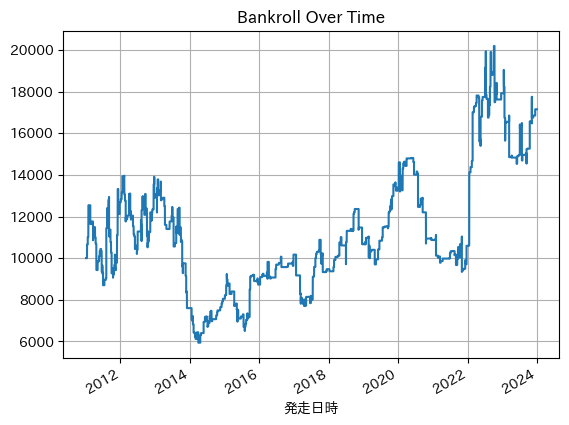

In [90]:
model = mlflow.sklearn.load_model("runs:/98527a062e994fe19b5fbab94ceeedca/model")

y_pred_proba_true = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

results = (
    pd.concat(
        [
            df_payout,
            pd.DataFrame(
                np.c_[y_test, y_pred, y_pred_proba_true],
                columns=["actual", "pred", "pred_proba_true"],
            ),
        ],
        axis=1,
    )
    .sort_values("発走日時", ascending=True)
    .reset_index(drop=True)
)

results["pred"] = results["pred"].astype(bool)
results["actual"] = results["actual"].astype(bool)


def kelly_criterion(b, p, q):
    return (b * p - q) / b


b = results["odds"] - 1
p = results["pred_proba_true"]
q = 1 - p
f_star = (kelly_criterion(b, p, q) * 0.2).clip(lower=0)
results["kelly_criterion"] = f_star

bankroll = 10_000
bankroll_history = []
bet_history = []
bets = []

for i, row in results.iterrows():
    bet_amount = row["kelly_criterion"] * bankroll
    bet_amount = (
        round(bet_amount / 100) * 100
    )  # bet amount must be in 100 yen increments
    bet = bet_amount > 0 and row["pred_proba_true"] >= 0.675
    if bet and row["actual"] is True:
        bankroll += (row["odds"] - 1) * bet_amount
        bet_history.append(bet_amount)
        bets.append(True)
    elif bet and row["actual"] is False:
        bankroll -= bet_amount
        bet_history.append(bet_amount)
        bets.append(True)
    else:
        bet_history.append(0)
        bets.append(False)
    bankroll_history.append(bankroll)

results["bankroll"] = bankroll_history
results["bet_amount"] = bet_history
results["bet"] = bets

results.set_index("発走日時")["bankroll"].plot(grid=True, title="Bankroll Over Time");